In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import sys
sys.path.insert(0, '../')
# sys.path.insert(0, '/other/dir')
from sold2.model.line_matcher import LineMatcher
from sold2.misc.visualize_util import plot_images, plot_lines, plot_line_matches, plot_color_line_matches, plot_keypoints
from torch.nn.functional import softmax
from utils.point_utils import MyPointMatchModel

In [74]:
ckpt_path = '/home/nics/Work/sp-sold2/experiments/sp-sold2_full_wireframe/checkpoint-epoch053-end.tar'
# sp_ckpt_path = 'pretrained_models/superpoint_v1.pth'
device = 'cuda'
mode = 'dynamic'  # 'dynamic' or 'static'

# Initialize the line matcher
config = {
    'model_cfg': {
        'model_name': "sp_simple",
        'model_architecture': "simple",
        # Backbone related config
        'backbone': "superpoint",
        'backbone_cfg': {
            'input_channel': 1, # Use RGB images or grayscale images.
            'depth': 4,
            'num_stacks': 2,
            'num_blocks': 1,
            'num_classes': 5
        },
        # Junction decoder related config
        'junction_decoder': "superpoint_decoder",
        'junc_decoder_cfg': {},
        # Heatmap decoder related config
        'heatmap_decoder': "pixel_shuffle",
        'heatmap_decoder_cfg': {},
        # Descriptor decoder related config
        'descriptor_decoder': "superpoint_descriptor",
        'descriptor_decoder_cfg': {},
        # Shared configurations
        'grid_size': 8,
        'keep_border_valid': True,
        # Threshold of junction detection
        'detection_thresh': 0.0153846, # 1/65
        'max_num_junctions': 300,
        # Threshold of heatmap detection
        'prob_thresh': 0.5,
        # Weighting related parameters
        'weighting_policy': mode,
        # [Heatmap loss]
        'w_heatmap': 0.,
        'w_heatmap_class': 1,
        'heatmap_loss_func': "cross_entropy",
        'heatmap_loss_cfg': {
            'policy': mode
        },
        # [Heatmap consistency loss]
        # [Junction loss]
        'w_junc': 0.,
        'junction_loss_func': "superpoint",
        'junction_loss_cfg': {
            'policy': mode
        },
        # [Descriptor loss]
        'w_desc': 0.,
        'descriptor_loss_func': "regular_sampling",
        'descriptor_loss_cfg': {
            'dist_threshold': 8,
            'grid_size': 4,
            'margin': 1,
            'policy': mode
        },
    },
    'line_detector_cfg': {
        'detect_thresh': 0.20,  # depending on your images, you might need to tune this parameter
        'num_samples': 64,
        'sampling_method': "local_max",
        'inlier_thresh': 0.9,
        "use_candidate_suppression": True,
        "nms_dist_tolerance": 3.,
        "use_heatmap_refinement": True,
        "heatmap_refine_cfg": {
            "mode": "local",
            "ratio": 0.2,
            "valid_thresh": 1e-3,
            "num_blocks": 20,
            "overlap_ratio": 0.5
        }
    },
    'multiscale': False,
    'line_matcher_cfg': {
        'cross_check': True,
        'num_samples': 5,
        'min_dist_pts': 8,
        'top_k_candidates': 10,
        'grid_size': 8
    },
    'point_detector_cfg': {
        'cell': 8,
        'conf_thresh': 0.0154,
        'nms_dist': 4,
        'border_remove': 4
    },
    'point_matcher_cfg': {
        'weights_path': '/home/plus/Work/plvins_ws/src/PL-VINS/feature_tracker/scripts/superpoint/superpoint_v1.pth',
        # img_glob: '*.png'
        # skip: 1   # Images to skip if input is movie or directory
        # show_extra: false  # Show extra debug outputs
        # display_scale: 2   # Factor to scale output visualization
        # min_length: 2  # Minimum length of point tracks
        'max_length': 5,  # Maximum length of point tracks
        'nms_dist': 4,    # Non Maximum Suppression (NMS) distance
        'conf_thresh': 0.015, # Detector confidence threshold
        'nn_thresh': 0.9, # Descriptor matching threshold 
        # camid: 0   # OpenCV webcam video capture ID
        # waitkey: 1 # OpenCV waitkey time in ms
        # cuda: false # Use cuda GPU to speed up network processing speed
        # H: 480 # Input image height
        # W: 752 # Input image width
        'min_cnt': 150
    }
}

line_matcher = LineMatcher(
        config["model_cfg"], ckpt_path, device, config["line_detector_cfg"],
        config["line_matcher_cfg"], config["multiscale"])
point_matcher = MyPointMatchModel(
        config['point_matcher_cfg']
)
model_cfg = config["model_cfg"]
# line_detector_cfg = config["line_detector_cfg"]
from sold2.model.model_util import get_model
from sold2.model.loss import get_loss_and_weights
from sold2.model.line_detection import LineSegmentDetectionModule
from sold2.train import convert_junc_predictions
from sold2.misc.train_utils import adapt_checkpoint
from sold2.model.line_detector import line_map_to_segments
_, loss_weights = get_loss_and_weights(model_cfg, device)

# Initialize the cnn backbone
model = get_model(model_cfg, loss_weights)
checkpoint = torch.load(ckpt_path, map_location=device)
checkpoint = adapt_checkpoint(checkpoint["model_state_dict"])
model.load_state_dict(checkpoint)
model = model.to(device)
model = model.eval()




	--------Initializing model----------
	 [Debug] Adding w_junc with value 0.000000 to model
	 [Debug] Adding w_heatmap with value 0.000000 to model
	 [Debug] Adding w_desc with value 0.000000 to model
	Model architecture: simple
	Backbone: superpoint
	Junction decoder: superpoint_decoder
	Heatmap decoder: pixel_shuffle
	-------------------------------------
[Debug] detect_thresh: 0.2
[Debug] num_samples: 64
[Debug] sampling_method: local_max
[Debug] inlier_thresh: 0.9
[Debug] use_candidate_suppression: True
[Debug] nms_dist_tolerance: 3.0
[Debug] use_heatmap_refinement: True
[Debug] heatmap_refine_cfg: {'mode': 'local', 'ratio': 0.2, 'valid_thresh': 0.001, 'num_blocks': 20, 'overlap_ratio': 0.5}


	--------Initializing model----------
	 [Debug] Adding w_junc with value 0.000000 to model
	 [Debug] Adding w_heatmap with value 0.000000 to model
	 [Debug] Adding w_desc with value 0.000000 to model
	Model architecture: simple
	Backbone: superpoint
	Junction decoder: superpoint_decoder
	Hea

In [97]:
# Read and pre-process the images
scale_factor = 1  # we recommend resizing the images to a resolution in the range 400~800 pixels
img1 = '../assets/0.png'
img1 = cv2.imread(img1, 0)
img1 = cv2.resize(img1, (img1.shape[1] // scale_factor, img1.shape[0] // scale_factor),
                  interpolation = cv2.INTER_AREA)
img1 = (img1 / 255.).astype(float)
torch_img1 = torch.tensor(img1, dtype=torch.float)[None, None]
with torch.no_grad():
    net_outputs1 = model(torch_img1.cuda())
img2 = '../assets/1.png'
img2 = cv2.imread(img2, 0)
img2 = cv2.resize(img2, (img2.shape[1] // scale_factor, img2.shape[0] // scale_factor),
                  interpolation = cv2.INTER_AREA)
img2 = (img2 / 255.).astype(float)
torch_img2 = torch.tensor(img2, dtype=torch.float)[None, None]
with torch.no_grad():
    net_outputs2 = model(torch_img2.cuda())


In [99]:
# Match the points
def nms_fast(in_corners, H, W, dist_thresh):
    """
    Run a faster approximate Non-Max-Suppression on numpy corners shaped:
      3xN [x_i,y_i,conf_i]^T

    Algo summary: Create a grid sized HxW. Assign each corner location a 1, rest
    are zeros. Iterate through all the 1's and convert them either to -1 or 0.
    Suppress points by setting nearby values to 0.

    Grid Value Legend:
    -1 : Kept.
      0 : Empty or suppressed.
      1 : To be processed (converted to either kept or supressed).

    NOTE: The NMS first rounds points to integers, so NMS distance might not
    be exactly dist_thresh. It also assumes points are within image boundaries.

    Inputs
      in_corners - 3xN numpy array with corners [x_i, y_i, confidence_i]^T.
      H - Image height.
      W - Image width.
      dist_thresh - Distance to suppress, measured as an infinty norm distance.
    Returns
      nmsed_corners - 3xN numpy matrix with surviving corners.
      nmsed_inds - N length numpy vector with surviving corner indices.
    """
    grid = np.zeros((H, W)).astype(int) # Track NMS data.
    inds = np.zeros((H, W)).astype(int) # Store indices of points.
    # Sort by confidence and round to nearest int.
    inds1 = np.argsort(-in_corners[2,:])
    corners = in_corners[:,inds1]
    rcorners = corners[:2,:].round().astype(int) # Rounded corners.
    # Check for edge case of 0 or 1 corners.
    if rcorners.shape[1] == 0:
      return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
    if rcorners.shape[1] == 1:
      out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
      return out, np.zeros((1)).astype(int)
    # Initialize the grid.
    for i, rc in enumerate(rcorners.T):
      grid[rcorners[1,i], rcorners[0,i]] = 1
      inds[rcorners[1,i], rcorners[0,i]] = i
    # Pad the border of the grid, so that we can NMS points near the border.
    pad = dist_thresh
    grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
    # Iterate through points, highest to lowest conf, suppress neighborhood.
    count = 0
    for i, rc in enumerate(rcorners.T):
      # Account for top and left padding.
      pt = (rc[0]+pad, rc[1]+pad)
      if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
        grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
        grid[pt[1], pt[0]] = -1
        count += 1
    # Get all surviving -1's and return sorted array of remaining corners.
    keepy, keepx = np.where(grid==-1)
    keepy, keepx = keepy - pad, keepx - pad
    inds_keep = inds[keepy, keepx]
    out = corners[:, inds_keep]
    values = out[-1, :]
    inds2 = np.argsort(-values)
    out = out[:, inds2]
    out_inds = inds1[inds_keep[inds2]]
    return out, out_inds
def pointProcess(junctions, coarse_desc, H, W, point_cfg):
    cell = point_cfg["cell"]
    conf_thresh = point_cfg["conf_thresh"]
    nms_dist = point_cfg["nms_dist"]
    border_remove = point_cfg["border_remove"]
    # H,W = img.shape 
    # semi = net_outputs["junctions"]
    # Convert pytorch -> numpy.
    semi = junctions.cpu().numpy().squeeze()
    # --- Process points.
    dense = np.exp(semi) # Softmax.
    dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
    # Remove dustbin.
    nodust = dense[:-1, :, :]
    # Reshape to get full resolution heatmap.
    Hc = int(H / cell)
    Wc = int(W / cell)
    nodust = nodust.transpose(1, 2, 0)
    heatmap = np.reshape(nodust, [Hc, Wc, cell, cell])
    heatmap = np.transpose(heatmap, [0, 2, 1, 3])
    heatmap = np.reshape(heatmap, [Hc*cell, Wc*cell])
    xs, ys = np.where(heatmap >= conf_thresh) # Confidence threshold.
    if len(xs) == 0:
      return np.zeros((3, 0)), None, None
    pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
    pts[0, :] = ys
    pts[1, :] = xs
    pts[2, :] = heatmap[xs, ys]
    pts, _ = nms_fast(pts, H, W, dist_thresh=nms_dist) # Apply NMS.
    inds = np.argsort(pts[2,:])
    pts = pts[:,inds[::-1]] # Sort by confidence.
    # Remove points along border.
    bord = border_remove
    toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
    toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
    toremove = np.logical_or(toremoveW, toremoveH)
    pts = pts[:, ~toremove]
    D = coarse_desc.shape[1]
    samp_pts = torch.from_numpy(pts[:2, :].copy())
    samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
    samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
    samp_pts = samp_pts.transpose(0, 1).contiguous()
    samp_pts = samp_pts.view(1, 1, -1, 2)
    samp_pts = samp_pts.float()
    samp_pts = samp_pts.cuda()
    desc = torch.nn.functional.grid_sample(coarse_desc, samp_pts)
    desc = desc.data.cpu().numpy().reshape(D, -1)
    desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]
    return pts, desc
junctions1 = net_outputs1["junctions"]
junctions2 = net_outputs2["junctions"]
# pts1 = pts1.transpose([1,2,0])
# pts2 = pts2.transpose([1,2,0])

H, W = img1.shape
print(pts1.shape, img1.shape)
coarse_desc1 = net_outputs1["descriptors"]
coarse_desc2 = net_outputs2["descriptors"]
pts1, desc1 = pointProcess(junctions1, coarse_desc1, H, W, config["point_detector_cfg"])
pts2, desc2 = pointProcess(junctions2, coarse_desc2, H, W, config["point_detector_cfg"])
print(pts1.shape, desc1.shape)


(3, 589) (512, 512)
(3, 589) (128, 589)


(589, 2)
(483, 3)


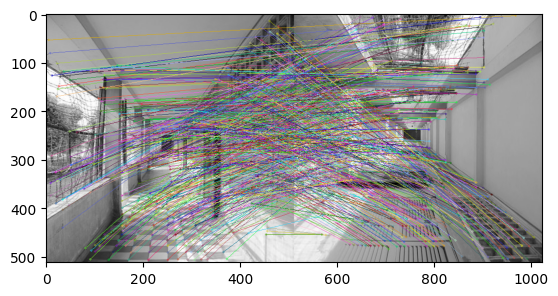

(512, 512) (512, 1024, 3)


In [100]:
def drawMatches(img1, kp1, img2, kp2, matches):
    """
    My own implementation of cv2.drawMatches as OpenCV 2.4.9
    does not have this function available but it's supported in
    OpenCV 3.0.0

    This function takes in two images with their associated 
    keypoints, as well as a list of DMatch data structure (matches) 
    that contains which keypoints matched in which images.

    An image will be produced where a montage is shown with
    the first image followed by the second image beside it.

    Keypoints are delineated with circles, while lines are connected
    between matching keypoints.

    img1,img2 - Grayscale images
    kp1,kp2 - Detected list of keypoints through any of the OpenCV keypoint 
              detection algorithms
    matches - A list of matches of corresponding keypoints through any
              OpenCV keypoint matching algorithm
    """

    # Create a new output image that concatenates the two images together
    # (a.k.a) a montage
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])

    # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:

        # Get the matching keypoints for each of the images
        img1_idx = mat[0]
        img2_idx = mat[1]

        # x - columns
        # y - rows
        (x1,y1) = kp1[int(img1_idx)]
        (x2,y2) = kp2[int(img2_idx)]

        # Draw a small circle at both co-ordinates
        # radius 4
        # colour blue
        # thickness = 1
        a = np.random.randint(0,256)
        b = np.random.randint(0,256)
        c = np.random.randint(0,256)

        cv2.circle(out, (int(np.round(x1)),int(np.round(y1))), 2, (a, b, c), 1)      #画圆，cv2.circle()参考官方文档
        cv2.circle(out, (int(np.round(x2)+cols1),int(np.round(y2))), 2, (a, b, c), 1)

        # Draw a line in between the two points
        # thickness = 1
        # colour blue
        cv2.line(out, (int(np.round(x1)),int(np.round(y1))), (int(np.round(x2)+cols1),int(np.round(y2))), (a, b, c), 1, shift=0)  #画线，cv2.line()参考官方文档

    # Also return the image if you'd like a copy
    return out

pts11 = pts1[0:2, :].transpose([1,0]).astype(int)
pts22 = pts2[0:2, :].transpose([1,0]).astype(int)
print(pts11.shape)
point_matches = point_matcher.match(desc1, desc2).transpose([1,0])
print(point_matches.shape)
match_result = drawMatches(img1*255, pts11, img2*255, pts22, point_matches)
plt.imshow(match_result)
plt.show()
print(img1.shape, match_result.shape)

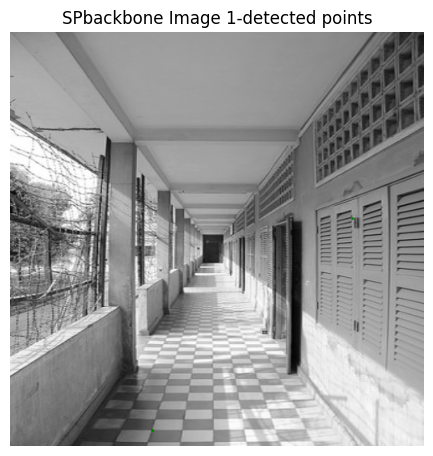

In [102]:
def plot_pts(pts_list, indices=[0], color="red"):
    fig = plt.gcf()
    ax = fig.axes
    # print(len(ax), max(indices))
    # assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, pts in zip(axes, pts_list):
        for i in range(pts.shape[1]):
            # print(pts[:,i])
            # p = pts[:, i]
            a.scatter(pts[0,i], pts[1,i], color=color, s=0.8)
plot_images([img1], ['SPbackbone Image 1-detected points'])
# plot_linesegs([line_seg1], ps=3, lw=2)
# plot_pts([pts1], indices=[0], color="red")

plot_pts([pts1[:, point_matches[0].astype(int)]], indices=[0], color="green")

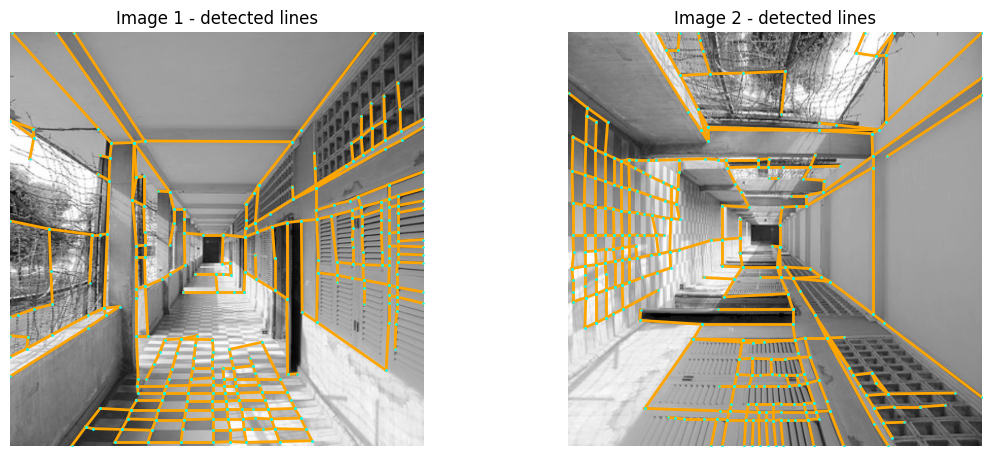

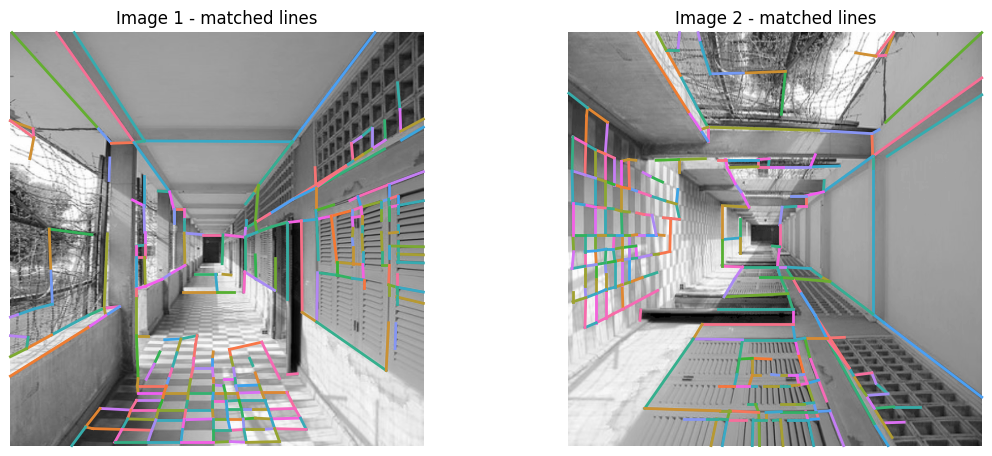

In [103]:
# Match the lines
outputs = line_matcher([torch_img1, torch_img2])
line_seg1 = outputs["line_segments"][0]
line_seg2 = outputs["line_segments"][1]
matches = outputs["matches"]

valid_matches = matches != -1
match_indices = matches[valid_matches]
matched_lines1 = line_seg1[valid_matches][:, :, ::-1]
matched_lines2 = line_seg2[match_indices][:, :, ::-1]


# Plot the matches
plot_images([img1, img2], ['Image 1 - detected lines', 'Image 2 - detected lines'])
plot_lines([line_seg1[:, :, ::-1], line_seg2[:, :, ::-1]], ps=3, lw=2)
plot_images([img1, img2], ['Image 1 - matched lines', 'Image 2 - matched lines'])
plot_color_line_matches([matched_lines1, matched_lines2], lw=2)